In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from mmseg.models.uda.swinir_backbone import MGDNRefinement
from mmseg.models.uda.refinement import EncodeDecode
from tqdm import tqdm
import numpy as np
from refinement_module import UNet
from torch.optim.lr_scheduler import OneCycleLR
import random
from models import Refine
from Datasets import RefinementDataset

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WeiHDataset(Dataset):
    def __init__(self,train_data_root="data/WeiH/",val_train_root="data/I3/",mode="train"):
        super().__init__()
        if mode == "train":
            sam_mode = "sam"
            self.sam_paths = glob.glob(os.path.join(train_data_root,sam_mode,"*_pseudoTrainIds.png"),recursive=True)
            self.labels = list(map(partial(self.transform_to_label),self.sam_paths))

        elif mode == "val":
            sam_mode = "sam"
            self.sam_paths = glob.glob(os.path.join(val_train_root,sam_mode,"*_pseudoTrainIds.png"),recursive=True)
            self.labels = list(map(partial(self.transform_to_label),self.sam_paths))[:5000]

    def transform_to_label(self,path:str):
        path = path.replace("sam","labels")
        label_path = path.replace("_pseudoTrainIds.png","_labelTrainIds.png")
        return label_path

    def __len__(self):
        return len(self.labels)

    def open_image(self, path):
        img = Image.open(path).convert("P")

        img = np.array(img)
        img.setflags(write=True)

        return tensor(img).unsqueeze(0)

    def __getitem__(self, index):
        sam_image = self.open_image(self.sam_paths[index])
        gt_image  = self.open_image(self.labels[index])
        return sam_image*255, gt_image

In [3]:
ds = WeiHDataset(mode="val")

In [4]:
a = ds[1][0].float().unsqueeze(0)

In [5]:
a.shape

torch.Size([1, 1, 256, 256])

In [6]:
ds[1][1].shape

torch.Size([1, 256, 256])

In [7]:
model = MGDNRefinement()

In [8]:
model(a,a).shape

torch.Size([1, 19, 256, 256])

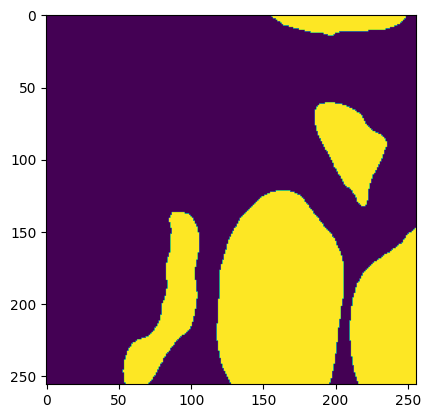

In [9]:
plt.imshow(a.squeeze())

In [10]:
def compute_iou(preds:torch.Tensor,gt:torch.Tensor,num_classes=2,ignore_index=255):
    mask = gt != ignore_index
    preds = preds[mask]
    gt = gt[mask]

    iou_list = []

    for cls in range(num_classes):
        cls_in_preds = preds == cls
        cls_in_gt = gt == cls

        intersection = (cls_in_preds & cls_in_gt).sum().item()
        union = (cls_in_preds | cls_in_gt).sum().item()

        if union == 0:
            iou_list.append(0)
            continue  # this class is not present in gt

        iou = intersection / union
        iou_list.append(iou)

    if not iou_list:
        raise ValueError("No class found in this predictions")
    return sum(iou_list) / len(iou_list)

def plot(pl:torch.Tensor,
         sam:torch.Tensor,
         preds:torch.Tensor,
         gt:torch.Tensor,
         epoch,
         batch_id,
         model_name,
         dataset_type,mask_type
         ):
    if batch_id % 200==0:
        pl = pl.squeeze().detach().cpu().numpy()
        sam = sam.squeeze().detach().cpu().numpy()
        preds = preds.squeeze().detach().cpu().numpy()
        gt = gt.squeeze().detach().cpu().numpy()

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

        axes[0].imshow(pl)
        axes[0].set_title("Pseudo label de l'EMA")

        axes[1].imshow(sam)
        axes[1].set_title("SAM")

        axes[2].imshow(preds)
        axes[2].set_title("Prédictions du raffineur")

        axes[3].imshow(gt)
        axes[3].set_title("Ground truth")

        plt.tight_layout()

        os.makedirs(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug", exist_ok=True)
        plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug/{epoch}_{batch_id}.png")
        plt.close(fig)

def save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_m_iou, label="Train mIoU")
    plt.plot(val_m_iou, label="Val mIoU")
    plt.legend()
    plt.title("Mean IoU")
    plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/metrics.png")
    plt.close()


def one_batch(model,model_name,epoch,device,
              batch,batch_id,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    model.train() if on_training else model.eval()
    if dataset_type == "i3":
        pl,sam,gt = batch
        pl,sam,gt = pl.float(),sam.float(),gt.long()
        pl,sam,gt = pl.to(device),sam.to(device),gt.to(device)
        preds = model(pl,sam)
    else :
        sam,gt = batch
        sam,gt = sam.float(),gt.long()
        sam,gt = sam.to(device),gt.to(device)
        preds = model(sam,sam) 
    loss = loss_function(preds,gt.squeeze(1))
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = preds.argmax(dim=1)

    iou = compute_iou(preds,gt.squeeze(1))

    if not on_training :
        if dataset_type == "i3":
            plot(pl,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)
        else :
            plot(sam,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)

    return loss.item(), iou


def one_epoch(model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training)
        if batch_id % 100 == 0: 
            print("train_loss = ",loss," epoch = ",epoch," batch_id = ",batch_id)
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type,mask_type):
    train_losses = []
    val_losses = []
    train_m_iou = []
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    weight = torch.tensor([1.,5.],device=device)  
    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    progress_bar = tqdm(range(max_epochs))

    if dataset_type == "i3":
        train_dataset = "i3"
        val_dataset = "i3"
    else:
        train_dataset = "weih"
        val_dataset = "weih"
    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=train_dataset,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=val_dataset,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
        # save losses and IoU
        save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type=mask_type)
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/best_checkpoint.pth")

In [11]:
train_ds = RefinementDataset(mode="train",)
val_ds = RefinementDataset(mode="val",)
train_dl = DataLoader(train_ds,2,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

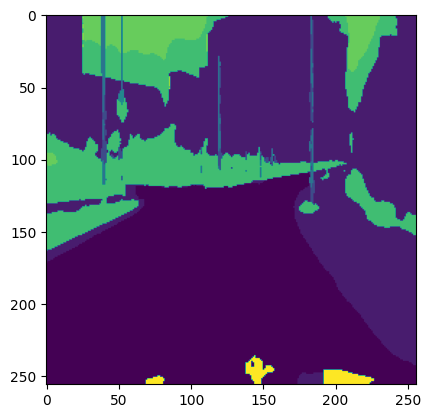

In [12]:
plt.imshow(train_ds[0][0].squeeze())

In [13]:
len(train_dl),len(val_dl)

(1488, 500)

In [14]:
torch.cuda.empty_cache()

In [15]:
model = EncodeDecode("cpu")

In [16]:
train(model,50,1e-4,train_dl,val_dl,"Refine","i3","colour")

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss =  163.22752380371094  epoch =  0  batch_id =  0
train_loss =  1.950554370880127  epoch =  0  batch_id =  100
train_loss =  1.454578161239624  epoch =  0  batch_id =  200
train_loss =  1.4466480016708374  epoch =  0  batch_id =  300
train_loss =  1.265320062637329  epoch =  0  batch_id =  400
train_loss =  1.035609245300293  epoch =  0  batch_id =  500
train_loss =  1.6839661598205566  epoch =  0  batch_id =  600
train_loss =  1.1643705368041992  epoch =  0  batch_id =  700
train_loss =  0.998058557510376  epoch =  0  batch_id =  800
train_loss =  1.160865306854248  epoch =  0  batch_id =  900
train_loss =  1.0867865085601807  epoch =  0  batch_id =  1000
train_loss =  0.9434676766395569  epoch =  0  batch_id =  1100
train_loss =  0.9460723400115967  epoch =  0  batch_id =  1200
train_loss =  0.7339674830436707  epoch =  0  batch_id =  1300
train_loss =  1.1718156337738037  epoch =  0  batch_id =  1400
train_loss =  0.8722418546676636  epoch =  0  batch_id =  0
train_loss = 

  2%|▏         | 1/50 [08:01<6:33:30, 481.86s/it, train_loss=1.92, train_iou=0.568, val_loss=1.04, val_iou=0.614]

train_loss =  0.8394328951835632  epoch =  1  batch_id =  0
train_loss =  1.1763420104980469  epoch =  1  batch_id =  100
train_loss =  0.8716718554496765  epoch =  1  batch_id =  200
train_loss =  0.9453372955322266  epoch =  1  batch_id =  300
train_loss =  0.7582679986953735  epoch =  1  batch_id =  400
train_loss =  0.6410066485404968  epoch =  1  batch_id =  500
train_loss =  0.7931637167930603  epoch =  1  batch_id =  600
train_loss =  1.3399193286895752  epoch =  1  batch_id =  700
train_loss =  0.5241895914077759  epoch =  1  batch_id =  800
train_loss =  0.8482921123504639  epoch =  1  batch_id =  900
train_loss =  0.5611534118652344  epoch =  1  batch_id =  1000
train_loss =  0.9518915414810181  epoch =  1  batch_id =  1100
train_loss =  0.8664105534553528  epoch =  1  batch_id =  1200
train_loss =  0.8548576235771179  epoch =  1  batch_id =  1300
train_loss =  0.579932689666748  epoch =  1  batch_id =  1400
train_loss =  0.8321936130523682  epoch =  1  batch_id =  0
train_lo

  4%|▍         | 2/50 [15:55<6:21:37, 477.03s/it, train_loss=0.984, train_iou=0.665, val_loss=0.958, val_iou=0.62]

train_loss =  0.8469467759132385  epoch =  2  batch_id =  0
train_loss =  0.7539601922035217  epoch =  2  batch_id =  100
train_loss =  0.8400292992591858  epoch =  2  batch_id =  200
train_loss =  0.8443741202354431  epoch =  2  batch_id =  300
train_loss =  0.9728145003318787  epoch =  2  batch_id =  400
train_loss =  0.7867620587348938  epoch =  2  batch_id =  500
train_loss =  1.1843852996826172  epoch =  2  batch_id =  600
train_loss =  1.0785130262374878  epoch =  2  batch_id =  700
train_loss =  0.74388587474823  epoch =  2  batch_id =  800
train_loss =  0.5540657639503479  epoch =  2  batch_id =  900
train_loss =  1.155744194984436  epoch =  2  batch_id =  1000
train_loss =  1.1594665050506592  epoch =  2  batch_id =  1100
train_loss =  0.7978715300559998  epoch =  2  batch_id =  1200
train_loss =  1.2868590354919434  epoch =  2  batch_id =  1300
train_loss =  0.7150086760520935  epoch =  2  batch_id =  1400
train_loss =  0.7096422910690308  epoch =  2  batch_id =  0
train_loss

  6%|▌         | 3/50 [23:06<5:57:10, 455.97s/it, train_loss=0.877, train_iou=0.684, val_loss=0.87, val_iou=0.63] 

train_loss =  0.5662892460823059  epoch =  3  batch_id =  0
train_loss =  0.9560039639472961  epoch =  3  batch_id =  100
train_loss =  0.5727326273918152  epoch =  3  batch_id =  200
train_loss =  0.8038567900657654  epoch =  3  batch_id =  300
train_loss =  0.6449675559997559  epoch =  3  batch_id =  400
train_loss =  0.7302333116531372  epoch =  3  batch_id =  500
train_loss =  0.5940413475036621  epoch =  3  batch_id =  600
train_loss =  0.8988754153251648  epoch =  3  batch_id =  700
train_loss =  0.5782241821289062  epoch =  3  batch_id =  800
train_loss =  2.6508092880249023  epoch =  3  batch_id =  900
train_loss =  0.7966744303703308  epoch =  3  batch_id =  1000
train_loss =  0.8895062804222107  epoch =  3  batch_id =  1100
train_loss =  0.8306117653846741  epoch =  3  batch_id =  1200
train_loss =  1.0248842239379883  epoch =  3  batch_id =  1300
train_loss =  0.7244364023208618  epoch =  3  batch_id =  1400
train_loss =  0.7760453224182129  epoch =  3  batch_id =  0
train_l

  8%|▊         | 4/50 [30:03<5:37:51, 440.69s/it, train_loss=0.804, train_iou=0.7, val_loss=0.838, val_iou=0.656]

train_loss =  0.6252089738845825  epoch =  4  batch_id =  0
train_loss =  0.8840009570121765  epoch =  4  batch_id =  100
train_loss =  0.6759307980537415  epoch =  4  batch_id =  200
train_loss =  0.6874193549156189  epoch =  4  batch_id =  300
train_loss =  0.7389295697212219  epoch =  4  batch_id =  400
train_loss =  0.8192235827445984  epoch =  4  batch_id =  500
train_loss =  1.066176176071167  epoch =  4  batch_id =  600
train_loss =  0.5557950139045715  epoch =  4  batch_id =  700
train_loss =  0.6774330139160156  epoch =  4  batch_id =  800
train_loss =  0.6606075763702393  epoch =  4  batch_id =  900
train_loss =  0.566323459148407  epoch =  4  batch_id =  1000
train_loss =  0.5612308979034424  epoch =  4  batch_id =  1100
train_loss =  0.41883385181427  epoch =  4  batch_id =  1200
train_loss =  0.8483902812004089  epoch =  4  batch_id =  1300
train_loss =  0.8008885383605957  epoch =  4  batch_id =  1400
train_loss =  0.6530258059501648  epoch =  4  batch_id =  0
train_loss 

 10%|█         | 5/50 [36:58<5:23:34, 431.44s/it, train_loss=0.756, train_iou=0.716, val_loss=0.756, val_iou=0.67]

train_loss =  0.44057267904281616  epoch =  5  batch_id =  0
train_loss =  0.8317835927009583  epoch =  5  batch_id =  100
train_loss =  0.7997598648071289  epoch =  5  batch_id =  200
train_loss =  0.7612901329994202  epoch =  5  batch_id =  300
train_loss =  0.47205477952957153  epoch =  5  batch_id =  400
train_loss =  0.37948620319366455  epoch =  5  batch_id =  500
train_loss =  1.0780065059661865  epoch =  5  batch_id =  600
train_loss =  0.6407963037490845  epoch =  5  batch_id =  700
train_loss =  0.6404402256011963  epoch =  5  batch_id =  800
train_loss =  0.9956384897232056  epoch =  5  batch_id =  900
train_loss =  0.7063046097755432  epoch =  5  batch_id =  1000
train_loss =  0.8004052639007568  epoch =  5  batch_id =  1100
train_loss =  0.9043745994567871  epoch =  5  batch_id =  1200
train_loss =  0.6821627020835876  epoch =  5  batch_id =  1300
train_loss =  0.4639146327972412  epoch =  5  batch_id =  1400
train_loss =  0.6464097499847412  epoch =  5  batch_id =  0
trai

 12%|█▏        | 6/50 [44:00<5:13:53, 428.04s/it, train_loss=0.716, train_iou=0.726, val_loss=0.737, val_iou=0.673]

train_loss =  0.803333580493927  epoch =  6  batch_id =  0
train_loss =  0.6242981553077698  epoch =  6  batch_id =  100
train_loss =  0.6317616105079651  epoch =  6  batch_id =  200
train_loss =  0.5821080207824707  epoch =  6  batch_id =  300
train_loss =  0.7924829125404358  epoch =  6  batch_id =  400
train_loss =  0.826269805431366  epoch =  6  batch_id =  500
train_loss =  0.7766634821891785  epoch =  6  batch_id =  600
train_loss =  0.78789883852005  epoch =  6  batch_id =  700
train_loss =  0.7145736813545227  epoch =  6  batch_id =  800
train_loss =  0.5841326117515564  epoch =  6  batch_id =  900
train_loss =  1.1183688640594482  epoch =  6  batch_id =  1000
train_loss =  0.9729381203651428  epoch =  6  batch_id =  1100
train_loss =  0.6792686581611633  epoch =  6  batch_id =  1200
train_loss =  0.5860278606414795  epoch =  6  batch_id =  1300
train_loss =  0.6526668071746826  epoch =  6  batch_id =  1400
train_loss =  0.5706719160079956  epoch =  6  batch_id =  0
train_loss 

 14%|█▍        | 7/50 [51:01<5:05:07, 425.75s/it, train_loss=0.679, train_iou=0.736, val_loss=0.701, val_iou=0.689]

train_loss =  0.6642965078353882  epoch =  7  batch_id =  0
train_loss =  0.6567984819412231  epoch =  7  batch_id =  100
train_loss =  0.6336283087730408  epoch =  7  batch_id =  200
train_loss =  0.6011661887168884  epoch =  7  batch_id =  300
train_loss =  0.6709774136543274  epoch =  7  batch_id =  400
train_loss =  0.6712067127227783  epoch =  7  batch_id =  500
train_loss =  0.41000792384147644  epoch =  7  batch_id =  600
train_loss =  0.9769728183746338  epoch =  7  batch_id =  700
train_loss =  0.5623889565467834  epoch =  7  batch_id =  800
train_loss =  0.8272955417633057  epoch =  7  batch_id =  900
train_loss =  0.6964358687400818  epoch =  7  batch_id =  1000
train_loss =  0.8199337720870972  epoch =  7  batch_id =  1100
train_loss =  0.9440566301345825  epoch =  7  batch_id =  1200
train_loss =  1.2685385942459106  epoch =  7  batch_id =  1300
train_loss =  0.7718424201011658  epoch =  7  batch_id =  1400
train_loss =  0.7318434715270996  epoch =  7  batch_id =  0
train_

 16%|█▌        | 8/50 [58:16<5:00:08, 428.76s/it, train_loss=0.648, train_iou=0.743, val_loss=0.675, val_iou=0.688]

train_loss =  0.3295029401779175  epoch =  8  batch_id =  0
train_loss =  0.8585016131401062  epoch =  8  batch_id =  100
train_loss =  0.5552302598953247  epoch =  8  batch_id =  200
train_loss =  0.5161847472190857  epoch =  8  batch_id =  300
train_loss =  0.6370680332183838  epoch =  8  batch_id =  400
train_loss =  0.7620913982391357  epoch =  8  batch_id =  500
train_loss =  0.39770621061325073  epoch =  8  batch_id =  600
train_loss =  0.5820420980453491  epoch =  8  batch_id =  700
train_loss =  0.6723600625991821  epoch =  8  batch_id =  800
train_loss =  0.48520198464393616  epoch =  8  batch_id =  900
train_loss =  0.45053452253341675  epoch =  8  batch_id =  1000
train_loss =  0.8142353892326355  epoch =  8  batch_id =  1100
train_loss =  0.5919280052185059  epoch =  8  batch_id =  1200
train_loss =  0.536149799823761  epoch =  8  batch_id =  1300
train_loss =  0.5690487623214722  epoch =  8  batch_id =  1400
train_loss =  0.5381394624710083  epoch =  8  batch_id =  0
train

 18%|█▊        | 9/50 [1:05:11<4:50:07, 424.58s/it, train_loss=0.623, train_iou=0.75, val_loss=0.687, val_iou=0.684]

train_loss =  0.4364297091960907  epoch =  9  batch_id =  0
train_loss =  0.38426676392555237  epoch =  9  batch_id =  100
train_loss =  0.7010094523429871  epoch =  9  batch_id =  200
train_loss =  1.7533349990844727  epoch =  9  batch_id =  300
train_loss =  0.8076331615447998  epoch =  9  batch_id =  400
train_loss =  0.45403286814689636  epoch =  9  batch_id =  500
train_loss =  0.4639259874820709  epoch =  9  batch_id =  600
train_loss =  0.5409897565841675  epoch =  9  batch_id =  700
train_loss =  0.7169188857078552  epoch =  9  batch_id =  800
train_loss =  1.054772138595581  epoch =  9  batch_id =  900
train_loss =  0.5286421775817871  epoch =  9  batch_id =  1000
train_loss =  0.4878949820995331  epoch =  9  batch_id =  1100
train_loss =  0.3749016225337982  epoch =  9  batch_id =  1200
train_loss =  0.6591128706932068  epoch =  9  batch_id =  1300
train_loss =  0.6848571300506592  epoch =  9  batch_id =  1400
train_loss =  0.6521516442298889  epoch =  9  batch_id =  0
train_

 20%|██        | 10/50 [1:12:11<4:41:58, 422.96s/it, train_loss=0.602, train_iou=0.756, val_loss=0.679, val_iou=0.693]

train_loss =  0.6308446526527405  epoch =  10  batch_id =  0
train_loss =  0.6913802623748779  epoch =  10  batch_id =  100
train_loss =  0.5015910863876343  epoch =  10  batch_id =  200
train_loss =  0.6165603995323181  epoch =  10  batch_id =  300
train_loss =  0.5354235768318176  epoch =  10  batch_id =  400
train_loss =  0.5156835913658142  epoch =  10  batch_id =  500
train_loss =  0.533420205116272  epoch =  10  batch_id =  600
train_loss =  0.5794740915298462  epoch =  10  batch_id =  700
train_loss =  0.6751874685287476  epoch =  10  batch_id =  800
train_loss =  0.183481827378273  epoch =  10  batch_id =  900
train_loss =  0.5868054628372192  epoch =  10  batch_id =  1000
train_loss =  0.5023965835571289  epoch =  10  batch_id =  1100
train_loss =  0.9015896916389465  epoch =  10  batch_id =  1200
train_loss =  0.6642726063728333  epoch =  10  batch_id =  1300
train_loss =  0.4985129237174988  epoch =  10  batch_id =  1400
train_loss =  0.6114687919616699  epoch =  10  batch_i

 22%|██▏       | 11/50 [1:19:27<4:37:32, 426.98s/it, train_loss=0.573, train_iou=0.76, val_loss=0.633, val_iou=0.708] 

train_loss =  0.4979993402957916  epoch =  11  batch_id =  0
train_loss =  0.3378792107105255  epoch =  11  batch_id =  100
train_loss =  0.3897768557071686  epoch =  11  batch_id =  200
train_loss =  0.4141056537628174  epoch =  11  batch_id =  300
train_loss =  0.42867472767829895  epoch =  11  batch_id =  400
train_loss =  0.4693763554096222  epoch =  11  batch_id =  500
train_loss =  0.6499413847923279  epoch =  11  batch_id =  600
train_loss =  0.5896896719932556  epoch =  11  batch_id =  700
train_loss =  0.8341608047485352  epoch =  11  batch_id =  800
train_loss =  0.5900788307189941  epoch =  11  batch_id =  900
train_loss =  0.43959400057792664  epoch =  11  batch_id =  1000
train_loss =  0.7616890668869019  epoch =  11  batch_id =  1100
train_loss =  0.563238263130188  epoch =  11  batch_id =  1200
train_loss =  1.054853916168213  epoch =  11  batch_id =  1300
train_loss =  0.485880047082901  epoch =  11  batch_id =  1400
train_loss =  0.5653570890426636  epoch =  11  batch_

 24%|██▍       | 12/50 [1:26:38<4:31:13, 428.26s/it, train_loss=0.542, train_iou=0.765, val_loss=0.626, val_iou=0.705]

train_loss =  0.4990338385105133  epoch =  12  batch_id =  0
train_loss =  0.2717975974082947  epoch =  12  batch_id =  100
train_loss =  0.23248223960399628  epoch =  12  batch_id =  200
train_loss =  0.40526026487350464  epoch =  12  batch_id =  300
train_loss =  0.5405747890472412  epoch =  12  batch_id =  400
train_loss =  0.5503506660461426  epoch =  12  batch_id =  500
train_loss =  0.555419385433197  epoch =  12  batch_id =  600
train_loss =  0.4725055694580078  epoch =  12  batch_id =  700
train_loss =  0.4615793228149414  epoch =  12  batch_id =  800
train_loss =  0.5445775389671326  epoch =  12  batch_id =  900
train_loss =  0.5857532024383545  epoch =  12  batch_id =  1000
train_loss =  0.43562954664230347  epoch =  12  batch_id =  1100
train_loss =  0.5740578770637512  epoch =  12  batch_id =  1200
train_loss =  1.1302975416183472  epoch =  12  batch_id =  1300
train_loss =  0.82525634765625  epoch =  12  batch_id =  1400
train_loss =  0.5888292789459229  epoch =  12  batch

 26%|██▌       | 13/50 [1:33:59<4:26:33, 432.25s/it, train_loss=0.517, train_iou=0.776, val_loss=0.625, val_iou=0.696]

train_loss =  0.33333003520965576  epoch =  13  batch_id =  0


 26%|██▌       | 13/50 [1:34:24<4:28:42, 435.74s/it, train_loss=0.517, train_iou=0.776, val_loss=0.625, val_iou=0.696]


KeyboardInterrupt: 